# Experimenal Section

---

The primary goal here is to see that players are reaching a Nash Equilibrium and that they also respect their constraints given at initialization. 
To do that we plot a spyder graph of all distributions of the players and the Nash Gap over time. This notebook is separated into 9 parts:

| # | Description |
| --- | --- |
|`1`|Setting Up the Environment|
|`2`|Defining Helper Functions|
|`3`|Defining the Player|
|`4`|Updating Lambda Values|
|`5`|Gradient Descent Step|
|`6`|Computing the Nash Gap|
|`7`|Auxiliary Visualization Code|
|`8`|Setting Up the Environment|
|`9`|Main Loop and Results|


# Part 1: Setting Up the Environment

In this section, we import all the necessary libraries for our experiment. We use `random` for generating random numbers, `numpy` for numerical operations, `matplotlib.pyplot` for data visualization, `scipy.optimize.linprog` for linear programming solutions, and `networkx` for creating graphs.

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import networkx as nx

plt.style.use('ggplot')

# Part 2: Defining Helper Functions

In this section, we define a series of helper functions to aid in the computation of the Nash Equilibrium and visualization of strategies.

`total_expected_load()`: This function calculates the total expected load on all edges in the graph given the current strategies of all players.

`single_expected_load()`: This function calculates the expected load on each edge for a single player's strategy.

`projsplx()`: This function performs projection to simplex. This is useful for ensuring our computed strategies are valid probability distributions.

`total_effective_congestion()`: This function calculates the effective congestion on all edges of the graph. It differentiates between the highway and the road network by applying a congestion multiplier to the highway edges.

`create_dag()`: This function creates the directed acyclic graph (DAG) of our problem. The graph includes three roads and a highway, all connected to a common source 's' and target 't'.

In [4]:
def total_expected_load(G, players):
    """Calculates the total expected load for all edges in the graph."""
    expected_loads = {edge: 0 for edge in G.edges()}
    for player in players.values():
        for path_index, prob in enumerate(player.strategy):
            path = player.paths[path_index]
            for i in range(len(path)-1):
                edge = (path[i], path[i+1])
                expected_loads[edge] += prob
    return expected_loads

def single_expected_load(G, strategy, paths):
    """Calculates the expected load for each edge in the graph for a single strategy."""
    expected_loads = {edge: 0 for edge in G.edges()}
    for path_index, prob in enumerate(strategy):
        path = paths[path_index]
        for i in range(len(path)-1):
            edge = (path[i], path[i+1])
            expected_loads[edge] += prob
    return expected_loads

def projsplx(y):
    """Projection to Simplex"""
    s = np.sort(y)
    n = len(y) ; flag = False
    
    parsum = 0
    tmax = -np.inf
    for idx in range(n-2, -1, -1):
        parsum += s[idx+1]
        tmax = (parsum - 1) / (n - (idx + 1) )
        if tmax >= s[idx]:
            flag = True ; break
    
    if not flag:
        tmax = (np.sum(s) - 1) / n
    
    return np.maximum(y - tmax, 0)
   
def total_effective_congestion(true_cong_dict, cong_mult):
    """Function that translates effective load to congestion, 
    differentiating the highway from the road network"""
    highway = set()
    highway.add(('s','hw'))
    highway.add(('hw','t'))
    
    ret_dict = dict()

    for edge in true_cong_dict:

        if edge in highway:
            ret_dict[edge] = cong_mult*true_cong_dict[edge]
        else: 
            ret_dict[edge] = true_cong_dict[edge]

    return ret_dict

def create_dag():
    """Function that creates our DAG of interest"""
    G = nx.DiGraph()
    
    # Add nodes s and t to the graph
    G.add_node('s')
    G.add_node('t')
    
    # Add some edges to the graph
    G.add_edge('s', 'r1')
    G.add_edge('r1', 't')

    G.add_edge('s', 'r2')
    G.add_edge('r2', 't')

    G.add_edge('s', 'r3')
    G.add_edge('r3', 't')
    
    G.add_edge('s', 'hw')
    G.add_edge('hw', 't')

    return G

# Part 3: Defining the Player

The player contains various functions, the most important of which is:

`primal_gradient()`: Calculates the gradient of the objective function. This gradient is used in the projected gradient descent algorithm to update the player's strategy.

In [5]:
class Player:

    def __init__(self, name, G, gas):

        """Initializes a Player with the given name, graph, and gas amount."""
        self.name = name  # player identifier
        self.G = G  # graph representation
        self.gas = gas  # player's gas amount
        self.l = 0  # initial lambda value
        self.paths = self.find_all_paths(G,'s','t')  # all paths from source to target in the graph
        self.path_lengths = [2, 3, 4, 10]  # path lengths for constraint purposes

        # Initialize strategy with normalized random values
        initial_strategy = [random.random() for _ in range(len(self.paths))]
        self.strategy = np.array([x / sum(initial_strategy) for x in initial_strategy])

    def to_edge_list(self, path):
        """Converts a path to a list of edges."""
        return [(path[i], path[i+1]) for i in range(len(path) - 1)]

    def primal_gradient(self, exp_visitation, cong_mult):
        """Calculates the primal gradient based on expected visitation and congestion multiplier."""
        congestion_dict = total_effective_congestion(exp_visitation, cong_mult)

        primal_gradient = np.array([self.congestion_of_path(path, congestion_dict) for path in self.paths])
        constr_gradient = np.array(self.path_lengths)
        exp_constr = np.dot(constr_gradient, self.strategy)

        return primal_gradient if self.gas - exp_constr > 0 else primal_gradient + self.l*constr_gradient
    
    def find_all_paths(self, dag, source, sink, path=[]):
        """Recursively finds all paths from source to sink in a directed acyclic graph."""
        path = path + [source]
        if source == sink:
            return [path]
        paths = []
        for child in dag[source]:
            for new_path in self.find_all_paths(dag, child, sink, path):
                paths.append(new_path)
        return paths

    def congestion_of_path(self, path, congestion_dict):
        """Calculates the total congestion along a path."""
        return sum(congestion_dict[(path[i], path[i+1])] for i in range(len(path) - 1))

# Part 4: Updating Lambda Values

The update of lambda is done in one iteration for each player since we have an analytical expression of the maximum lambda for a given strategy profile, since we use a regularizer. The regularizer is a parameter that controls the rate of updating the lambda values and it plays a crucial role in the speed of convergence of the algorithm.

In [6]:
def update_lambda(players, regularizer):
    """Lambda update"""
    for player in players.values():

        # Calculate expected gas consumption and constraint violation
        expected_consumption = sum(x * y for x, y in zip(player.strategy, player.path_lengths))
        constraint_function = expected_consumption - player.gas

        # Replace lambda with new value
        player.l = max(0,constraint_function/(2*regularizer))

# Part 5: Gradient Descent Step

The `gradient_descent()` function calculates the gradient of the meta-objective function, accounting for the current values of the Lagrangian multipliers. By continuously adjusting the strategies in the direction of the negative gradient, the players minimize their individual costs, leading to a Nash equilibrium where no player can unilaterally and feasibly improve their individual cost.



In [7]:
def gradient_descent(G, players, x_stepsize, cong_mult):
    """Gradient descent step"""
    
    # Gradient calculation
    total_cong_dict = total_expected_load(G,players)
    all_grads = []
    for _,player in players.items():
        all_grads.append(player.primal_gradient(total_cong_dict, cong_mult))

    # Update strategies
    for idx,(_,player) in enumerate(players.items()):
        player.strategy = projsplx(player.strategy - x_stepsize * all_grads[idx])


# Part 6: Computing the Nash Gap

The functions below allow the calculation of the Nash Gap, given a product of strategies from all players.

The linear program is constructed as follows:

* The objective function is to minimize the total cost of the player's strategy.

* The inequality constraints ensure that the total gas consumption does not exceed the player's available gas.

* The equality constraints ensure that the player's strategy remains a valid probability distribution (i.e., the probabilities sum to one).

* The bounds impose the restriction that each probability must be between 0 and 1.

If the linear program is infeasible, the script prints an error message and exits. This should not happen in theory, as Slater condition holds.

In the end, the Nash gap provides a measure of the system's convergence to equilibrium. When the Nash gap is zero for all players, the system is at a Nash equilibrium.

In [8]:
def calculate_nash_gap(G, players, cong_mult):
    total_cong_dict = total_expected_load(G,players)
    gap_temp = []
    for player in players.values():
        gap_temp.append(abs(player_nash_gap(G, player, total_cong_dict, cong_mult)))
    return max(gap_temp)

def player_nash_gap(G, player, exp_visitation, cong_mult):

    self_load = single_expected_load(player.G, player.strategy, player.paths)
    rest_load = {key: exp_visitation[key] - self_load[key] for key in exp_visitation.keys()}

    hypothetical_dict = total_effective_congestion({edge : load + 1 for edge, load in rest_load.items()}, cong_mult)

    # pure_strategy_cost is a vector containing [f(x_1), f(x_2), ..., f(x_5)]
    # each entry is the cost for pure strategy i
    pure_strategy_cost = [None for _ in player.paths]
    for i in range(len(player.paths)):
        cost = 0
        for edge in player.to_edge_list(player.paths[i]):
            cost += hypothetical_dict[edge]
        pure_strategy_cost[i] = cost

    # same but for gas
    pure_strategy_utility = player.path_lengths
    
    # constraints for the linear program: ask rose about this if you're confused
    # if you're confused and you're rose, this is in your black notebook somewhere. good luck
    obj = pure_strategy_cost
    lhs_ineq = [player.path_lengths]
    rhs_ineq = [player.gas]
    lhs_eq = [[1 for _ in player.paths]]
    rhs_eq = [1]
    bnd = [(0, 1) for _ in player.paths]

    # Added recommended changes to linprog function call
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
                  A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd,
                  method="interior-point",
                  options={'cholesky': False, 'sym_pos': False, 'lstsq': True, 'presolve': True})

    if not opt.success:
        # problem!
        print('linear program was non-feasible somehow? exiting')
        sys.exit(-1)

    # now calculate the actual congestion experienced by this player
    actual_congestion = 0
    effective_congestion_dict = total_effective_congestion(exp_visitation, cong_mult)
    for i in range(len(player.paths)):
        path_congestion = 0
        for edge in player.to_edge_list(player.paths[i]):
            path_congestion += effective_congestion_dict[edge]
        actual_congestion += player.strategy[i] * path_congestion

    return actual_congestion - opt.fun

# Part 7: Auxiliary Visualization Code 

Below, we include two functions for plotting, one for plotting the spider plot and another to plot anything else in the form of a 1D function, such as the Nash Gap, the constraint violation and the values of lambda over time.

In [16]:
def plot_distributions(players):
    labels = np.array(['Road 1', 'Road 2', 'Road 3', 'Highway'])
    num_vars = len(labels)

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    labels = np.concatenate((labels,[labels[0]]))
    angles += angles[:1]

    # Size of the figure
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    plt.xticks(angles, labels, color='grey', size=12)

    # Draw ylabels, I chose to only display the max value
    ax.set_rlabel_position(30)
    plt.yticks([1], ['1'], color='grey', size=10)
    plt.ylim(0, 1)

    # Color dictionary for player names to match line color
    color_dict = {'Yellow': 'yellow', 'Red': 'red', 'Green': 'green', 'Blue': 'blue', 'Orange': 'orange'}

    for player in players.values():
        # The plot is a circle, so we need to "complete the loop"
        # and append the start value to the end.
        strategy = np.concatenate((player.strategy,[player.strategy[0]]))
        
        ax.plot(angles, strategy, linewidth=1, linestyle='solid', label=player.name, color=color_dict[player.name])
        ax.fill(angles, strategy, color=color_dict[player.name], alpha=0.05)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

def plot_graph(y_values, y_label, title):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(y_values) + 1), y_values, color='tab:red')
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

# Part 8: Setting Up the Experiment

In this part, we initiate the experiment and set up the parameters. Notice the gas constraints for all players. For example, the green player has a gas constraint of 9, which is pretty close to 10, maybe he selects the highway more in expectation.

In [17]:
G = create_dag()
players = dict()

t_iterates = 800
x_stepsize = 0.0005

regularizer = 0.01
hw_cong_mult = 0.1

player_gas_constraints = {
    'Red': 6,
    'Yellow': 3,
    'Green': 9,
    'Blue': 5,
    'Orange': 4
}

for color, gas_constraint in player_gas_constraints.items():
    players[color] = Player(color, G, gas_constraint)

# Part 9: Main Loop and Results

This final of the code executes the main loop of our experiment and visualizes the results. We initialize the empty lists for:
* constraint violation
* lagrangian multipliers
* nash gaps

After running `Algorithm 1` for `t` iterates, we call `plot_distributions()` to visualize the final strategy distribution for each player.

Starting Iteration 0/800


<ipython-input-8-e2652902c8c1>:37: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,


Starting Iteration 100/800
Starting Iteration 200/800
Starting Iteration 300/800
Starting Iteration 400/800
Starting Iteration 500/800
Starting Iteration 600/800
Starting Iteration 700/800


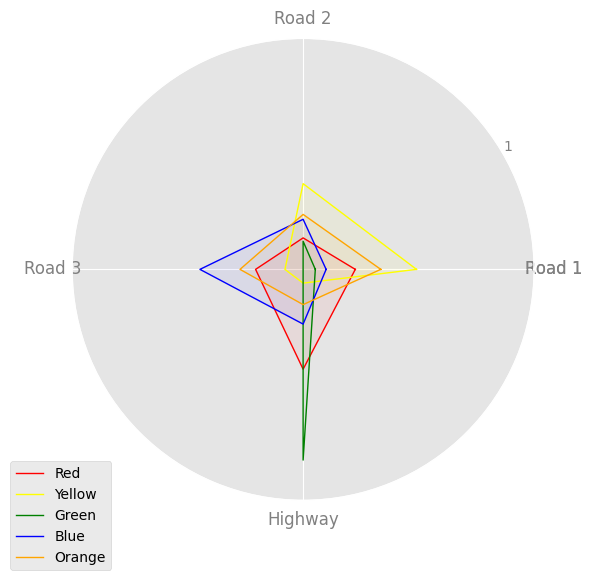

In [18]:
constr_list, l_list, gaps = [], [], []

for t in range(t_iterates):

    if t % 100 == 0:
        print(f"Starting Iteration {t}/{t_iterates}")

    # Find optimal lambda for iteration t
    update_lambda(players, regularizer)

    # Run a gradient descent step on Psi
    gradient_descent(G, players, x_stepsize,hw_cong_mult)

    constr_sum = 0
    l_sum = 0

    for player in players.values():
        # Calculate expected gas consumption and constraint violation
        expected_consumption = sum(x * y for x, y in zip(player.strategy, player.path_lengths))
        constraint_value = expected_consumption - player.gas
        if constraint_value < 0:
            constraint_value = 0

        # Sum up the constraint_function and player.l values
        constr_sum += constraint_value
        l_sum += player.l

    constr_list.append(constr_sum)
    l_list.append(l_sum)
    gaps.append(calculate_nash_gap(G, players, hw_cong_mult))

# plot_graph(gaps, 'Sum of nash_gap', 'Sum of nash_gap over time')
# plot_graph(constr_list, 'Constraint Function', 'Constraint Function Over Time')
# plot_graph(l_list, 'Player.l', 'Player.l Over Time')

# fig, axs = plt.subplots(len(players), 1, figsize=(8, 15))
# for idx, (player_name, player) in enumerate(players.items()):
#     axs[idx].bar(range(len(player.strategy)), player.strategy)
#     axs[idx].set_title(f'{player_name}')
#     axs[idx].set_xlabel('Strategy')
#     axs[idx].set_ylabel('Probability')
#     axs[idx].set_ylim([0, 1])
# plt.tight_layout()
# plt.show()

plot_distributions(players)

### Notice how the distributions are proportional to the gas available to each player

```
player_gas_constraints = {
    'Red': 6,
    'Yellow': 3,
    'Green': 9,
    'Blue': 5,
    'Orange': 4
}
```

### Finally we plot the Nas Gap that usually decays and approaches a small positive value.

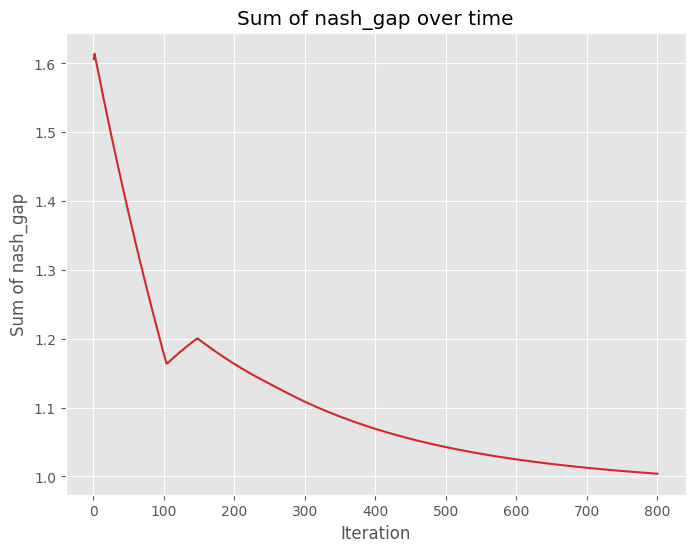

In [21]:
plot_graph(gaps, 'Sum of nash_gap', 'Sum of nash_gap over time')
# plot_graph(constr_list, 'Constraint Function', 'Constraint Function Over Time')
# plot_graph(l_list, 'Player.l', 'Player.l Over Time')